<img style="float: right;" src="images/Earthwave_logo.png" alt="earthwave" width="90"/> <img style="float: right;" src="images/UZH_logo.jpg" alt="uzh" width="200"/> <img style="float: right;" src="images/ESA_logo.png" alt="esa" width="150"/>


<img src="images/GlaMBIE_logo.png" alt="logo" width="400"/>

#<strong><font color='#11847C'> Gla</font>cier <font color='#11847C'>M</font>ass <font color='#11847C'>B</font>alance <font color='#11847C'>I</font>ntercomparison <font color='#11847C'>E</font>xercise - *A community effort to reconcile measurements of glacier mass balance*</strong>

##This Jupyter Notebook can be used to explore and visualise the final results from the Glacier Mass Balance Intercomparison Exercise (GlaMBIE). In the following code, you can choose from the 19 regions covered by the GlaMBIE project, and investigate the findings, including the mass change of the region.

<div>

## <strong>Getting started</strong>
</div>

First, we import the necessary packages

In [1]:
from google.cloud.storage import Client
import pandas as pd
import numpy as np
import glob, os
import matplotlib.pyplot as plt
from pathlib import Path

import ipywidgets as widgets

import seaborn as sns
sns.set_theme(palette='muted', style='whitegrid', font_scale=1.2)

In [23]:
def glambie_regions_dropdown(first_region_choice: str = None):
  regions = {'Alaska': 'alaska', 'Western Canada & US': 'western_canada_us', 'Arctic Canada North': 'arctic_canada_north', 'Arctic Canada South': 'arctic_canada_south', 'Greenland Periphery': 'greenland_periphery', 'Iceland': 'iceland', 'Svalbard': 'svalbard', 'Scandinavia': 'scandinavia', 'Russian Arctic': 'russian_arctic', 'North Asia': 'north_asia', 'Central Europe': 'central_europe', 'Caucasus & Middle East': 'caucasus_middle_east', 'Central Asia': 'central_asia', 'South Asia West': 'south_asia_west', 'Low Latitudes': 'low_latitudes', 'Southern Andes': 'southern_andes', 'New Zealand': 'new_zealand', 'Antarctic and Subantarctic Islands': 'antarctic_and_subantarctic'}
  if first_region_choice is not None:
    regions = {key:val for key, val in regions.items() if val != first_region_choice}
  a = widgets.Dropdown(
    options=regions,
    description='Region:'
)
  return a

In [29]:
def derivative_to_cumulative(start_dates, end_dates, changes, calculate_as_errors: bool = False):

    contains_no_gaps = [start_date == end_date for start_date, end_date in zip(start_dates[1:], end_dates[:-1])]
    # add an extra row to dataset for each gap, so that it's represented in the cumulative timeseries as no data
    if calculate_as_errors:
        changes = [0, *np.array(pd.Series(np.square(changes)).cumsum())**0.5]
    else:
        changes = [0, *np.array(pd.Series(changes).cumsum())]

    if not all(contains_no_gaps):
        indices_of_gaps = [i for i, x in enumerate(contains_no_gaps) if not (x)]
        start_dates = list(start_dates.copy())
        end_dates = list(end_dates.copy())
        for idx in indices_of_gaps:
            start_date_to_insert = end_dates[idx]
            end_date_to_insert = start_dates[idx + 1]
            # add no data row
            start_dates.insert(idx + 1, start_date_to_insert)
            end_dates.insert(idx + 1, end_date_to_insert)
            changes.insert(idx + 2, None)  # already in cumulative, hence +2
            # add last row before gap again after gap
            start_dates.insert(idx + 2, start_dates[idx + 1])
            end_dates.insert(idx + 2, end_dates[idx + 1])
            changes.insert(idx + 3, changes[idx + 1])  # already in cumulative, hence +3
    dates = [start_dates[0], *end_dates]

    if calculate_as_errors:
        return pd.DataFrame({'dates': dates, 'errors': changes})
    else:
        return pd.DataFrame({'dates': dates, 'changes': changes})

In [4]:
def transform_string(input_string):
    transformed_string = input_string.replace('_', ' ')
    capitalized_string = transformed_string.title()
    return capitalized_string

Next, we download the results of GlaMBIE from the WGMS server (*add more info here once the data is hosted in the final location*)

In [5]:
# replace this once data is available on WGMS server
DATA_TRANSFER_BUCKET_NAME = "glambie-submissions"
PROJECT_NAME = "glambie"
storage_client = Client(project=PROJECT_NAME)

list_of_blobs_in_bucket = storage_client.list_blobs(DATA_TRANSFER_BUCKET_NAME)
downloaded_files = []

for blob in list_of_blobs_in_bucket:
    if 'glambie_csvs_to_publish_v2.zip' in blob.name:
        downloaded_files.append(blob.name)
        destination_file_path = os.path.join(blob.name)
        Path(destination_file_path).parent.mkdir(parents=True, exist_ok=True)
        with open(destination_file_path, "wb") as output_file:
            blob.download_to_file(output_file, raw_download=False)

Each of the results files is downloaded to the current Colab working environment.

<div>

## <strong>Choose a region</strong>
</div>

In this section, you can pick from the 19 RGI regions. The region that you chose will be read in from file.

In [6]:
local_path = '/data/ox1/working/glambie/demo_notebooks'

In [14]:
temporal_option = 'hydrological_years'
data_directory = local_path + '/glambie_csvs_to_publish' + '/' + temporal_option

In [15]:
list_of_csvs = sorted(glob.glob(os.path.join(data_directory, '*.csv')))

In [9]:
# choose a region
region = glambie_regions_dropdown()
region

Dropdown(description='Region:', options={'Alaska': 'alaska', 'Western Canada & US': 'western_canada_us', 'Arct…

In [25]:
for filename in list_of_csvs:
    if region.value in filename:
        region_dataframe = pd.read_csv(filename)

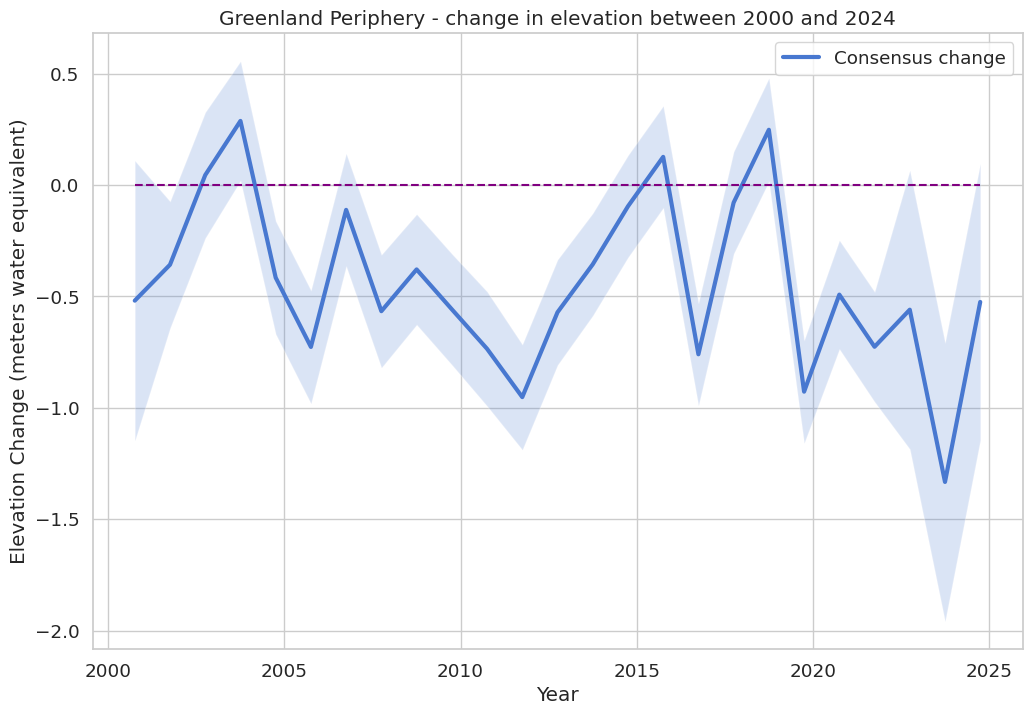

In [26]:
plt.subplots(1, 1, figsize=(12,8))

plt.plot(region_dataframe.end_dates, region_dataframe.consensus_mwe, linewidth=3, zorder=2, label='Consensus change')
plt.fill_between(region_dataframe.end_dates, region_dataframe.consensus_mwe - region_dataframe.consensus_mwe_errors, region_dataframe.consensus_mwe + region_dataframe.consensus_mwe_errors, alpha=0.2)
plt.hlines(0, region_dataframe.end_dates.values[0], region_dataframe.end_dates.values[-1], linestyle='dashed', color='purple')
plt.xlabel('Year')
plt.ylabel('Elevation Change (meters water equivalent)')
plt.title(transform_string(region.value) + ' - change in elevation between 2000 and 2024')

plt.legend()

<div>

## <strong>Plot ice loss for the reigon you have chosen</strong>
</div>

In [30]:
# Start with a simple mwe plot - explain that the following plot shows how many m of ice each region has lost over the last 24 years
cumulative_data_all_mwe = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_mwe)
cumulative_errors_all_mwe = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_mwe_errors, calculate_as_errors=True)

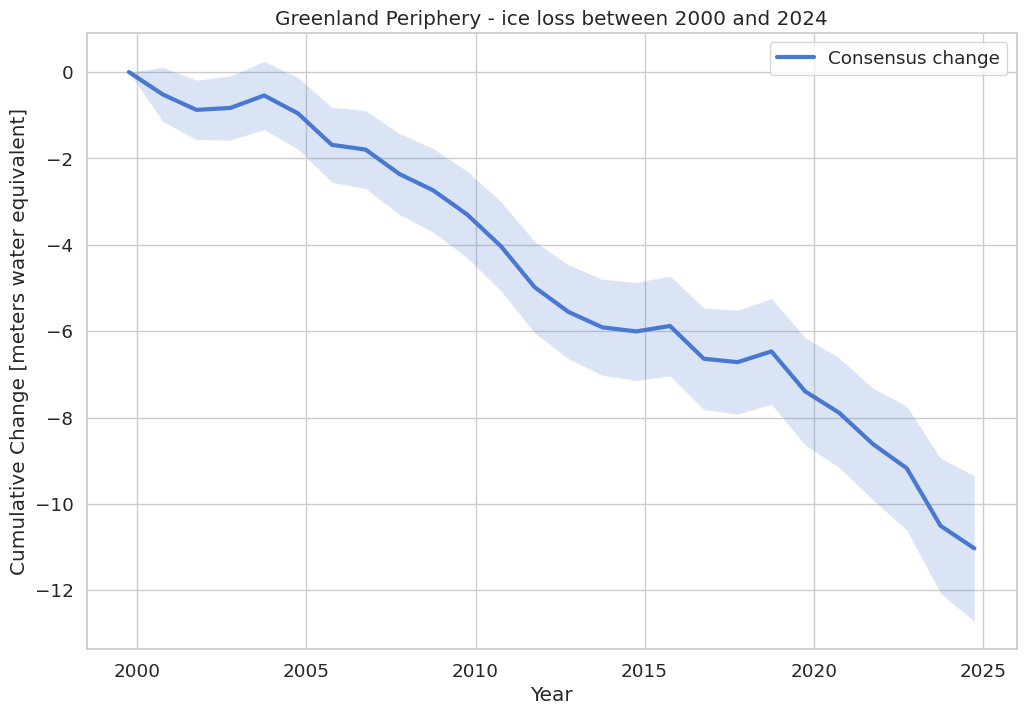

In [32]:
plt.subplots(1, 1, figsize=(12,8))

plt.plot(cumulative_data_all_mwe.dates, cumulative_data_all_mwe.changes, linewidth=3, zorder=2, label='Consensus change')
plt.fill_between(cumulative_data_all_mwe.dates, cumulative_data_all_mwe.changes - cumulative_errors_all_mwe.errors, cumulative_data_all_mwe.changes + cumulative_errors_all_mwe.errors, alpha=0.2)#
plt.xlabel('Year')
plt.ylabel('Cumulative Change [meters water equivalent]')
plt.title(transform_string(region.value) + ' - ice loss between 2000 and 2024')

plt.legend()

In [33]:
# convert to cumulative changes - Gt all
cumulative_data_all_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_gt)
cumulative_errors_all_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.consensus_gt_errors, calculate_as_errors=True)

In [34]:
cumulative_data_altimetry_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.altimetry_gt)
cumulative_data_gravimetry_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.gravimetry_gt)
cumulative_data_demdiff_and_glaciological_gt = derivative_to_cumulative(region_dataframe.start_dates, region_dataframe.end_dates, region_dataframe.demdiff_and_glaciological_gt)

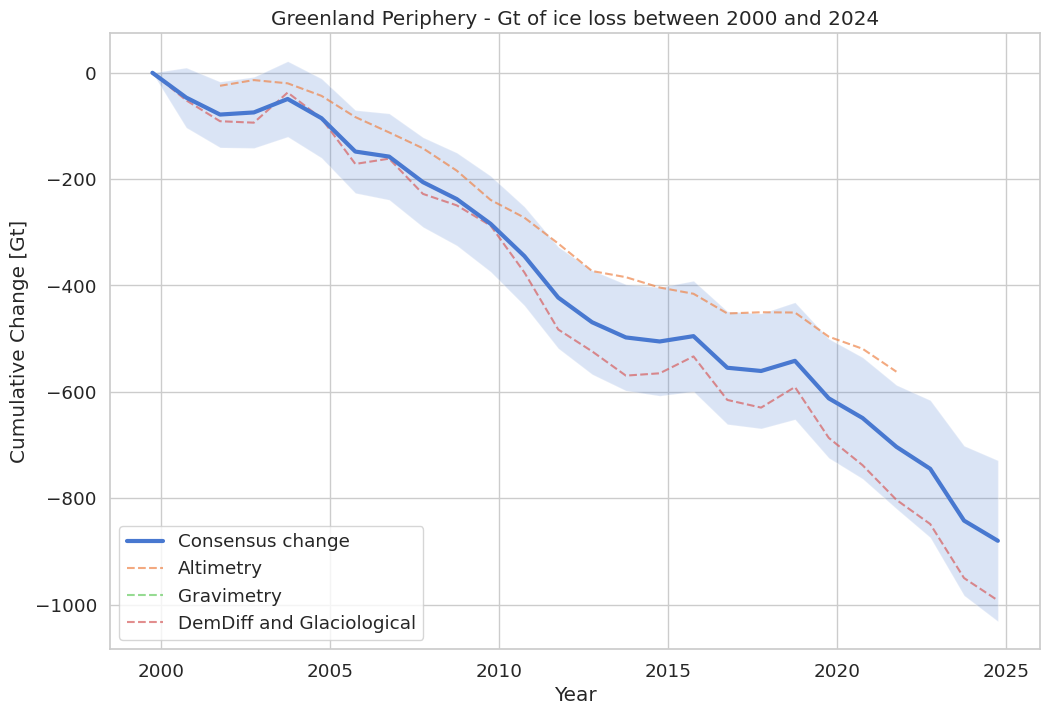

In [35]:
plt.subplots(1, 1, figsize=(12,8))

plt.plot(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes, linewidth=3, zorder=2, label='Consensus change')
plt.fill_between(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes - cumulative_errors_all_gt.errors, cumulative_data_all_gt.changes + cumulative_errors_all_gt.errors, alpha=0.2)#
plt.plot(cumulative_data_altimetry_gt.dates, cumulative_data_altimetry_gt.changes, linestyle='dashed', zorder=1, alpha=0.7, label='Altimetry')
plt.plot(cumulative_data_gravimetry_gt.dates, cumulative_data_gravimetry_gt.changes, linestyle='dashed', zorder=1, alpha=0.7, label='Gravimetry')
plt.plot(cumulative_data_demdiff_and_glaciological_gt.dates, cumulative_data_demdiff_and_glaciological_gt.changes, linestyle='dashed', zorder=1, alpha=0.7, label='DemDiff and Glaciological')
plt.xlabel('Year')
plt.ylabel('Cumulative Change [Gt]')
plt.title(transform_string(region.value) + ' - Gt of ice loss between 2000 and 2024')

plt.legend(loc='lower left')

In [40]:
comparison_region = glambie_regions_dropdown(region.value)
comparison_region

Dropdown(description='Region:', options={'Alaska': 'alaska', 'Western Canada & US': 'western_canada_us', 'Arct…

In [41]:
for filename in list_of_csvs:
    if comparison_region.value in filename:
        region_dataframe_comparison = pd.read_csv(filename)

In [42]:
cumulative_data_all_gt_comparison = derivative_to_cumulative(region_dataframe_comparison.start_dates, region_dataframe_comparison.end_dates, region_dataframe_comparison.consensus_gt)
cumulative_errors_all_gt_comparison = derivative_to_cumulative(region_dataframe_comparison.start_dates, region_dataframe_comparison.end_dates, region_dataframe_comparison.consensus_gt_errors, calculate_as_errors=True)

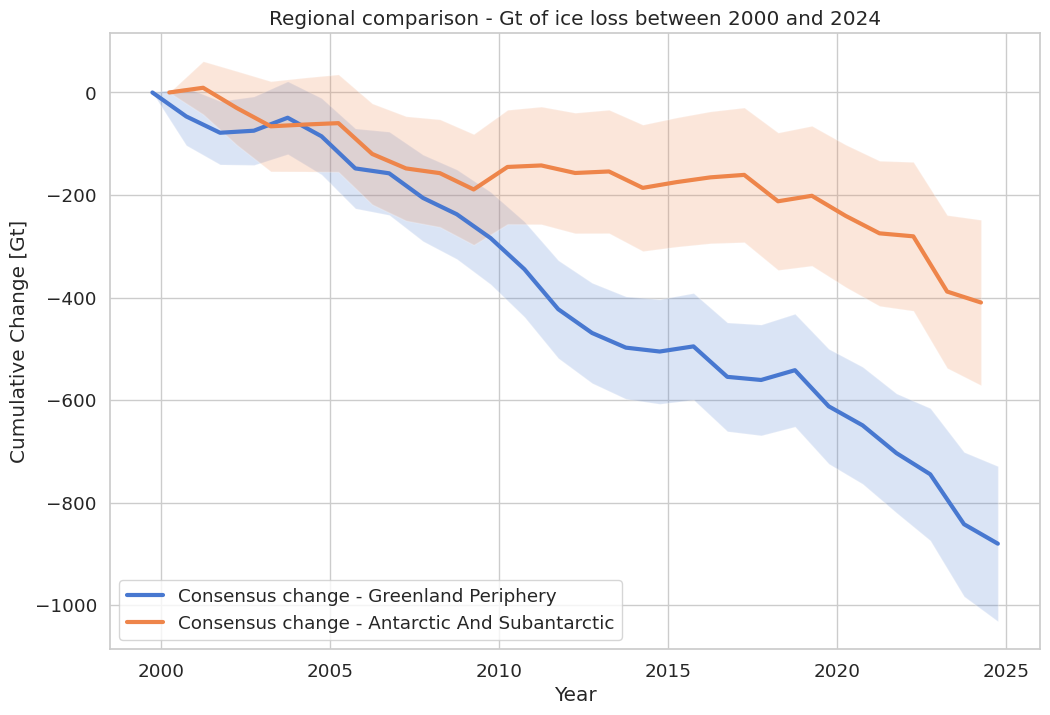

In [44]:
plt.subplots(1, 1, figsize=(12,8))

plt.plot(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes, linewidth=3, zorder=2, label='Consensus change - ' + transform_string(region.value))
plt.fill_between(cumulative_data_all_gt.dates, cumulative_data_all_gt.changes - cumulative_errors_all_gt.errors, cumulative_data_all_gt.changes + cumulative_errors_all_gt.errors, alpha=0.2)

plt.plot(cumulative_data_all_gt_comparison.dates, cumulative_data_all_gt_comparison.changes, linewidth=3, zorder=2, label='Consensus change - ' + transform_string(comparison_region.value))
plt.fill_between(cumulative_data_all_gt_comparison.dates, cumulative_data_all_gt_comparison.changes - cumulative_errors_all_gt_comparison.errors, cumulative_data_all_gt_comparison.changes + cumulative_errors_all_gt_comparison.errors, alpha=0.2)

plt.xlabel('Year')
plt.ylabel('Cumulative Change [Gt]')
plt.title('Regional comparison - Gt of ice loss between 2000 and 2024')

plt.legend(loc = 'lower left')